# FaIR Harmonized
### Erica Simon, 02/05/24
## Purpose: input harmonized historical and projected emissions trajectories into FaIR
- Emissions span 1750 to 2100
- For now, we will not run probabilistic projections


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pooch

from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties

## Global Variables

In [2]:
species_configs = pooch.retrieve(
    url = 'https://raw.githubusercontent.com/OMS-NetZero/FAIR/master/examples/data/species_configs_properties_calibration1.2.0.csv',
    known_hash = '4f9d25b21d632cf35953842a627db4b1612b465f68b2a824afff017a7390053b',
)

solar_obj = pooch.retrieve(
    url = 'https://raw.githubusercontent.com/chrisroadmap/fair-add-hfc/main/data/solar_erf_timebounds.csv',
    known_hash = 'md5:98f6f4c5309d848fea89803683441acf',
)

volcanic_obj = pooch.retrieve(
    url = 'https://raw.githubusercontent.com/chrisroadmap/fair-calibrate/main/data/forcing/volcanic_ERF_1750-2101_timebounds.csv',
    known_hash = 'md5:c0801f80f70195eb9567dbd70359219d',
)

df_solar = pd.read_csv(solar_obj, index_col="year")
df_volcanic = pd.read_csv(volcanic_obj, index_col="timebounds")

# trim `solar_df` to only include 1750-2101.
s_yr_list = list(range(2102, 2301))
df_solar = df_solar.drop(s_yr_list)

In [3]:
GCAM_df = pd.read_csv('~/outputs/GCAM_harm.csv')
MSG_df = pd.read_csv('~/outputs/MSG_harm.csv')
REM_df = pd.read_csv('~/outputs/REM_harm.csv')

# remove 'Emissions|' from variable name
for df in [GCAM_df, MSG_df, REM_df]:
    for i in range(len(df.Variable.values)): 
        df.Variable.values[i] = df.Variable.values[i][10:]

In [4]:
# retrieve climate configs
fair_params_1_2_0_obj = pooch.retrieve(
    url = 'https://zenodo.org/record/10566813/files/calibrated_constrained_parameters.csv',
    known_hash = '76e2b9156ed26aa2730aa7023f1e40025a3637fe479df18e822120eff001848c'
)
df_configs = pd.read_csv(fair_params_1_2_0_obj, index_col=0)

# scaling factors for solar forcing
trend_shape = np.ones(352)
trend_shape[:352] = np.linspace(0, 1, 352)

## Create functional format

In [5]:
# input: a dataframe in IAM format with annual emission timeseries for all relevant FaIR species
# returns: a FaIR object that has already been run (check f.temperature for outcomes)

def run_fair(df_emis):
    f = FAIR()
    
    start = int(df_emis.columns[5])   # assumes IAM format consistent with harmonizer
    end = int(df_emis.columns[-1])+1
    f.define_time(start, end, 1)
    
    # use same scenario sames as those in emissions df
    f.define_scenarios(df_emis.Scenario.unique().tolist())
    
    f.define_configs(['c1'])   
    
    ##### define species and properties #####
    species, properties = read_properties(filename=species_configs)

    # removed in examples from fair-calibrate repo, specifically because future projections aren't available
    species.remove("Halon-1202")
    species.remove("NOx aviation")

    f.define_species(species, properties)
    
    # create empty emission and temp arrays
    f.allocate()   
    
    ##### fill emissions #####
    # # remove 'Emissions|' from variable name
    # for i in range(len(df_emis.Variable.values)): 
    #     df_emis.Variable.values[i] = df_emis.Variable.values[i][10:]
        
    for scen in df_emis.Scenario.unique():
        for var in df_emis.Variable.unique():
            if var in f.species:
                emis = df_emis.loc[df_emis['Variable'] == var].loc[df_emis['Scenario'] == scen].values[0][5:].reshape(351,1)
                fill(f.emissions, emis, scenario=scen, specie=var)
                
    ##### fill forcings #####
    for scen in f.scenarios:
        fill(f.forcing, df_volcanic, scenario=scen, specie='Volcanic')
        fill(f.forcing, df_solar, scenario=scen, specie='Solar')
        
    ##### set configs #####
    fill(f.climate_configs["ocean_heat_transfer"], [1.1, 1.6, 0.9], config='c1')
    fill(f.climate_configs["ocean_heat_capacity"], [8, 14, 100], config='c1')
    fill(f.climate_configs["deep_ocean_efficacy"], 1.1, config='c1')
    f.fill_species_configs()   # default values
    
    ##### initial conditions #####
    initialise(f.concentration, f.species_configs["baseline_concentration"])
    initialise(f.forcing, 0)
    initialise(f.temperature, 0)   # f.temperature refers to temperature anomaly above PI (288 K)
    initialise(f.cumulative_emissions, 0)
    initialise(f.airborne_emissions, 0)
    
    ##### RUN #####
    f.run()
    
    return f

## Run with each model

In [6]:
f_GCAM = run_fair(GCAM_df)
f_MSG = run_fair(MSG_df)
f_REM = run_fair(REM_df)

Running 7 projections in parallel:   0%|          | 0/351 [00:00<?, ?timesteps/s]

Running 7 projections in parallel:   0%|          | 0/351 [00:00<?, ?timesteps/s]

Running 7 projections in parallel:   0%|          | 0/351 [00:00<?, ?timesteps/s]

In [7]:
iam_names = {f_GCAM:'GCAM 6.0 NGFS',
             f_MSG:'MESSAGEix-GLOBIOM 1.1-M-R12',
             f_REM:'REMIND-MAgPIE 3.2-4.6'}

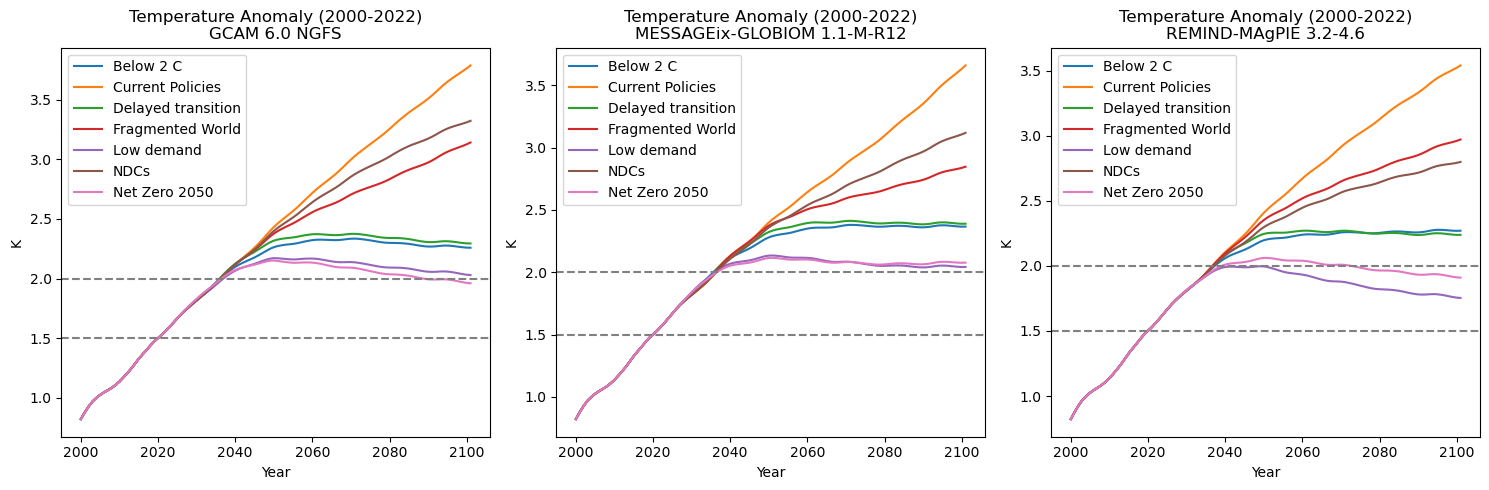

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, f in enumerate(iam_names):
    ax = axs[i]
    
    for scen in f.scenarios:
        ax.plot(f.timebounds[250:], f.temperature.loc[dict(scenario=scen, layer=0)][250:], label=scen)
    ax.set_xlabel('Year')
    ax.set_ylabel('K')
    ax.set_title('Temperature Anomaly (2000-2022)\n' + iam_names[f])
    ax.legend()
    ax.axhline(1.5, color='grey', linestyle='--')
    ax.axhline(2, color='grey', linestyle='--')


fig.tight_layout()
fig.show()

# Incorporate parameter uncertainty
adapt `run_fair` to include climate configs and generate probabilistic outcomes

## Helper functions

In [9]:
# helper function for `probabilistic_run_fair`
def fill_climate_configs(f, df_configs):
    fill(f.climate_configs["ocean_heat_capacity"], df_configs.loc[:, "clim_c1":"clim_c3"].values)
    fill(
        f.climate_configs["ocean_heat_transfer"],
        df_configs.loc[:, "clim_kappa1":"clim_kappa3"].values,
    )
    fill(f.climate_configs["deep_ocean_efficacy"], df_configs["clim_epsilon"].values.squeeze())
    fill(f.climate_configs["gamma_autocorrelation"], df_configs["clim_gamma"].values.squeeze())
    fill(f.climate_configs["sigma_eta"], df_configs["clim_sigma_eta"].values.squeeze())
    fill(f.climate_configs["sigma_xi"], df_configs["clim_sigma_xi"].values.squeeze())
    fill(f.climate_configs["seed"], df_configs["seed"])
    fill(f.climate_configs["stochastic_run"], True)
    fill(f.climate_configs["use_seed"], True)
    fill(f.climate_configs["forcing_4co2"], df_configs["clim_F_4xCO2"])

In [10]:
# helper function for `probabilistic_run_fair`
def edit_species_configs(f, species_configs):

    # carbon cycle
    fill(f.species_configs["iirf_0"], df_configs["cc_r0"].values.squeeze(), specie="CO2")
    fill(f.species_configs["iirf_airborne"], df_configs["cc_rA"].values.squeeze(), specie="CO2")
    fill(f.species_configs["iirf_uptake"], df_configs["cc_rU"].values.squeeze(), specie="CO2")
    fill(f.species_configs["iirf_temperature"], df_configs["cc_rT"].values.squeeze(), specie="CO2")

    # aerosol indirect
    fill(f.species_configs["aci_scale"], df_configs["aci_beta"].values.squeeze())
    fill(f.species_configs["aci_shape"], df_configs["aci_shape_so2"].values.squeeze(), specie="Sulfur")
    fill(f.species_configs["aci_shape"], df_configs["aci_shape_bc"].values.squeeze(), specie="BC")
    fill(f.species_configs["aci_shape"], df_configs["aci_shape_oc"].values.squeeze(), specie="OC")

    # aerosol direct
    for specie in [
        "BC", 
        "CH4", 
        "N2O",
        "NH3", 
        "NOx",
        "OC", 
        "Sulfur", 
        "VOC",
        "Equivalent effective stratospheric chlorine"
    ]:
        fill(f.species_configs["erfari_radiative_efficiency"], df_configs[f"ari_{specie}"], specie=specie)

    # forcing scaling
    for specie in [
        "CO2", 
        "CH4", 
        "N2O", 
        "Stratospheric water vapour",
        # "Contrails",   
        # contrails excluded from this version of calibration data "since few IAM scenarios provide detailed enough information to assess their future forcing"
        "Light absorbing particles on snow and ice", 
        "Land use"
    ]:
        fill(f.species_configs["forcing_scale"], df_configs[f"fscale_{specie}"].values.squeeze(), specie=specie)
    # the halogenated gases all take the same scale factor
    for specie in [
        "CFC-11",
        "CFC-12",
        "CFC-113",
        "CFC-114",
        "CFC-115",
        "HCFC-22",
        "HCFC-141b",
        "HCFC-142b",
        "CCl4",
        "CHCl3",
        "CH2Cl2",
        "CH3Cl",
        "CH3CCl3",
        "CH3Br",
        "Halon-1211",
        "Halon-1301",
        "Halon-2402",
        "CF4",
        "C2F6",
        "C3F8",
        "c-C4F8",
        "C4F10",
        "C5F12",
        "C6F14",
        "C7F16",
        "C8F18",
        "NF3",
        "SF6",
        "SO2F2",
        "HFC-125",
        "HFC-134a",
        "HFC-143a",
        "HFC-152a",
        "HFC-227ea",
        "HFC-23",
        "HFC-236fa",
        "HFC-245fa",
        "HFC-32",
        "HFC-365mfc",
        "HFC-4310mee",
    ]:
        fill(f.species_configs["forcing_scale"], df_configs["fscale_minorGHG"].values.squeeze(), specie=specie)

    # ozone
    for specie in ["CH4", "N2O", "Equivalent effective stratospheric chlorine", "CO", "VOC", "NOx"]:
        fill(f.species_configs["ozone_radiative_efficiency"], df_configs[f"o3_{specie}"], specie=specie)

    # initial value of CO2 concentration (but not baseline for forcing calculations)
    fill(
        f.species_configs["baseline_concentration"], 
        df_configs["cc_co2_concentration_1750"].values.squeeze(), 
        specie="CO2"
    )

## Functional form

In [11]:
# input: a dataframe in IAM format with annual emission timeseries for all relevant FaIR species
# returns: a FaIR object that has already been run, with ~800 climate configurations

def probabilistic_run_fair(df_emis):
    ##### create instance #####
    f = FAIR()

    ##### define time #####
    start = int(df_emis.columns[5])   # assumes IAM format consistent with harmonizer
    end = int(df_emis.columns[-1])+1
    f.define_time(start, end, 1)

    ##### define scenarios #####
    f.define_scenarios(df_emis.Scenario.unique().tolist())   # same as those in emission dataset

    ##### define configs #####
    configs = df_configs.index
    f.define_configs(configs) 

    ##### define species and properties #####
    species, properties = read_properties(filename=species_configs)
    species.remove("Halon-1202")
    species.remove("NOx aviation")
    f.define_species(species, properties)

    ##### create data arrays #####
    f.allocate()   

    ##### fill emissions #####
    # remove 'Emissions|' from variable name
    # for i in range(len(df_emis.Variable.values)): 
    #     df_emis.Variable.values[i] = df_emis.Variable.values[i][10:]

    for scen in df_emis.Scenario.unique():
        for var in df_emis.Variable.unique():
            if var in f.species:
                emis = df_emis.loc[df_emis['Variable'] == var].loc[df_emis['Scenario'] == scen].values[0][5:].reshape(351,1)
                fill(f.emissions, emis, scenario=scen, specie=var)

    ##### fill forcings #####
    for scen in f.scenarios:
        fill(
            f.forcing,
            (df_volcanic.values[:, None, None] * df_configs["fscale_Volcanic"].values.squeeze()).reshape(352, 841),
            specie="Volcanic", scenario=scen,
        )
        fill(
            f.forcing,
            (df_solar.values[:, None, None] * df_configs["fscale_solar_amplitude"].values).reshape(352, 841)
            + (trend_shape[:, None, None] * df_configs["fscale_solar_trend"].values).reshape(352, 841),
            specie="Solar", scenario=scen,
        )

    ##### set configs #####
    fill_climate_configs(f, df_configs)
    f.fill_species_configs(filename=species_configs)
    edit_species_configs(f, species_configs)  #  overwrite configs that we will vary as part of probabilstic sampling

    ##### initial conditions #####
    initialise(f.concentration, f.species_configs["baseline_concentration"])
    initialise(f.forcing, 0)
    initialise(f.temperature, 0)   # f.temperature refers to temperature anomaly above PI (288 K)
    initialise(f.cumulative_emissions, 0)
    initialise(f.airborne_emissions, 0)

    ##### RUN #####
    f.run()
    
    return f

## Run with each model

In [37]:
prob_f_GCAM = probabilistic_run_fair(GCAM_df)
prob_f_MSG = probabilistic_run_fair(MSG_df)
prob_f_REM = probabilistic_run_fair(REM_df)

KeyboardInterrupt: 

In [ ]:
prob_f_GCAM.temperature.to_netcdf('~/outputs/GCAM_prob_run')
prob_f_MSG.temperature.to_netcdf('~/outputs/MSG_prob_run')
prob_f_REM.temperature.to_netcdf('~/outputs/REM_prob_run')

In [ ]:
prob_iam_names = {prob_f_GCAM:'GCAM 6.0 NGFS',
                  prob_f_MSG:'MESSAGEix-GLOBIOM 1.1-M-R12',
                  prob_f_REM:'REMIND-MAgPIE 3.2-4.6'}

In [16]:
weights_51yr = np.ones(52)
weights_51yr[0] = 0.5
weights_51yr[-1] = 0.5

In [17]:
scenario_order = ["Net Zero 2050", "Low demand", "Below 2 C", "Delayed transition", 
                  "Fragmented World", "NDCs", "Current Policies"]

In [18]:
NGFS_colors = {
    "Net Zero 2050": "#00a9cf",
    "Below 2 C": "#003466",
    "NDCs": "#f69320",
    "Current Policies": "#df0000",
    "Low demand": "#2274ae",
    "Fragmented World": "#b0724e",
    "Delayed transition": "#92397a",
}

In [19]:
def plot_scenarios(f):
    fig, ax = plt.subplots(2, 4, figsize=(12, 6))

    for i, scenario in enumerate(scenario_order):
        for pp in ((0, 100), (5, 95), (16, 84)):
            ax[i // 4, i % 4].fill_between(
                f.timebounds,
                np.percentile(
                    f.temperature.loc[dict(scenario=scenario, layer=0)]
                    - np.average(
                        f.temperature.loc[
                            dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                        ],
                        weights=weights_51yr,
                        axis=0
                    ),
                    pp[0],
                    axis=1,
                ),
                np.percentile(
                    f.temperature.loc[dict(scenario=scenario, layer=0)]
                    - np.average(
                        f.temperature.loc[
                            dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                        ],
                        weights=weights_51yr,
                        axis=0
                    ),
                    pp[1],
                    axis=1,
                ),
                color=NGFS_colors[scenario],
                alpha=0.2,
                lw=0
            )

        ax[i // 4, i % 4].plot(
            f.timebounds,
            np.median(
                f.temperature.loc[dict(scenario=scenario, layer=0)]
                - np.average(
                    f.temperature.loc[
                        dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                    ],
                    weights=weights_51yr,
                    axis=0
                ),
                axis=1,
            ),
            color=NGFS_colors[scenario],
        )
    #     ax[i // 4, i % 4].plot(np.arange(1850.5, 2021), gmst, color="k")
        ax[i // 4, i % 4].set_xlim(1850, 2100)
        ax[i // 4, i % 4].set_ylim(-1, 6)
        ax[i // 4, i % 4].axhline(0, color="k", ls=":", lw=0.5)
        ax[i // 4, i % 4].set_title(scenario)

    plt.suptitle(prob_iam_names[f] + ': Temperature Anomalies')
    fig.tight_layout()

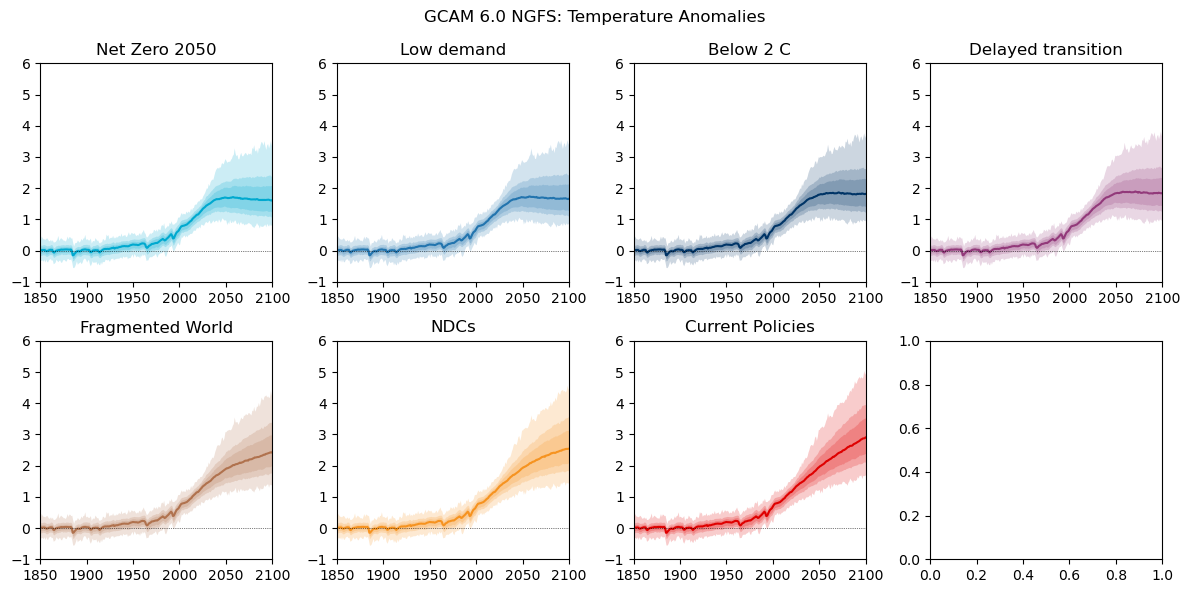

In [20]:
plot_scenarios(prob_f_GCAM)

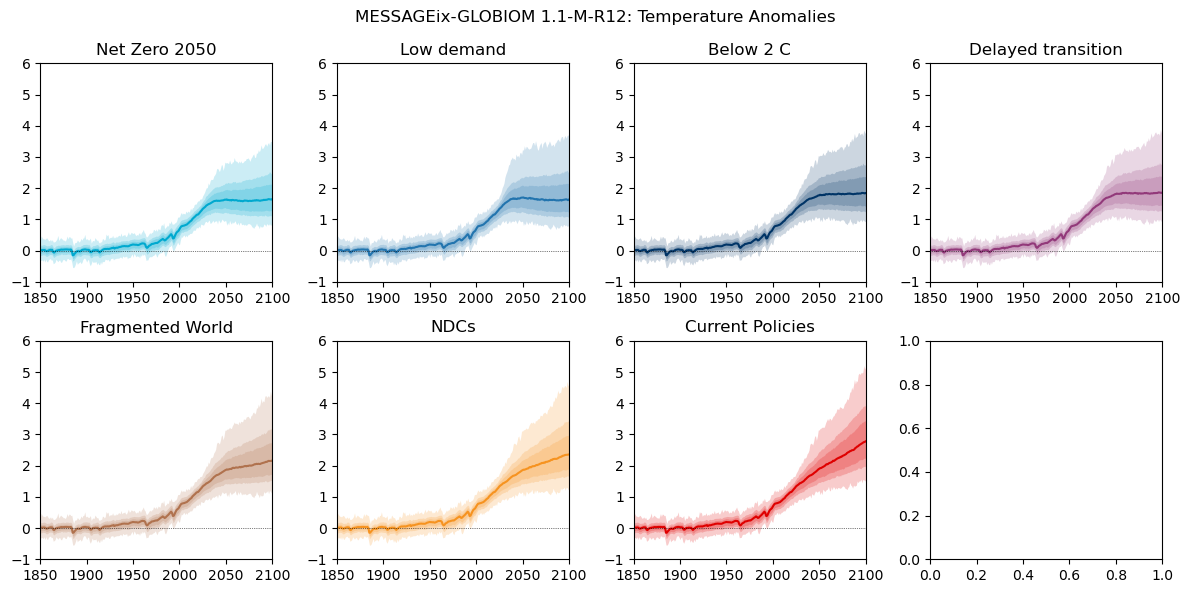

In [23]:
plot_scenarios(prob_f_MSG)

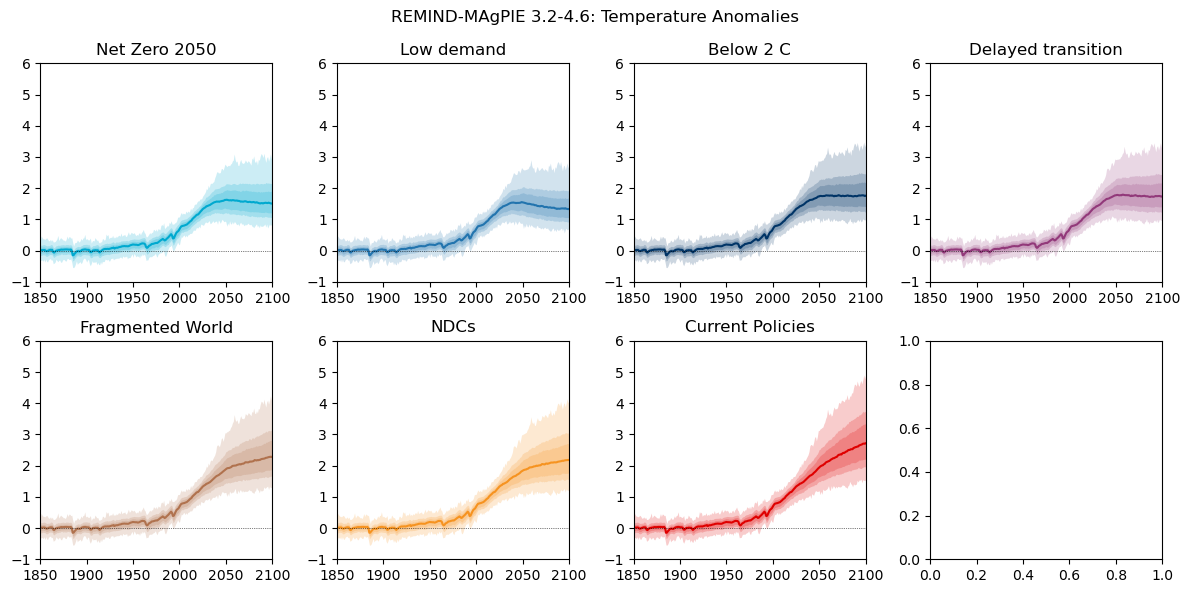

In [24]:
plot_scenarios(prob_f_REM)